In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
import os
import scipy.spatial.distance
import optparse
import json
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
import random
import librosa, IPython
import librosa.display as lplt

from tensorflow import keras
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from scipy.spatial.distance import cosine
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, Bidirectional, Lambda
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from collections import OrderedDict
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from xgboost import plot_tree, plot_importance

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

seed = 12
np.random.seed(seed)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

%matplotlib inline

In [2]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [3]:
# os.chdir('/content/drive/My Drive/ML Group Project/')

In [4]:
# os.getcwd()

In [5]:
df = pd.read_csv("features_3_sec.csv")
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [6]:
print("Dataset has",df.shape)
print("Count of Positive and Negative samples")
df.label.value_counts().reset_index()

Dataset has (9990, 60)
Count of Positive and Negative samples


,index,label
0,reggae,1000
1,jazz,1000
2,metal,1000
3,blues,1000
4,pop,1000
5,disco,999
6,hiphop,998
7,rock,998
8,classical,998
9,country,997


In [8]:
audio_fp = 'library/blues/blues.00000.wav'
audio_data, sr = librosa.load(audio_fp)
audio_data, _ = librosa.effects.trim(audio_data)

In [9]:
# play sample file
IPython.display.Audio(audio_data, rate=sr)

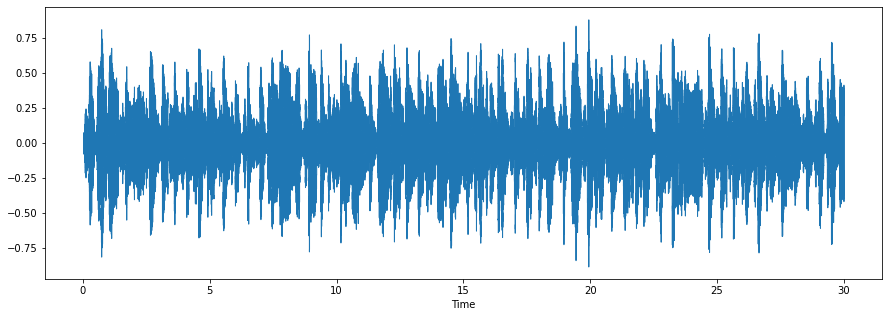

In [10]:
# plot sample file
plt.figure(figsize=(15,5))
lplt.waveshow(audio_data)
plt.show()

C:\Users\cmurdock\Anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  return f(*args, **kwargs)
C:\Users\cmurdock\Anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  return f(*args, **kwargs)


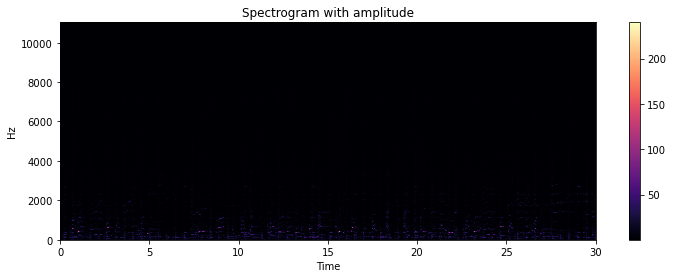

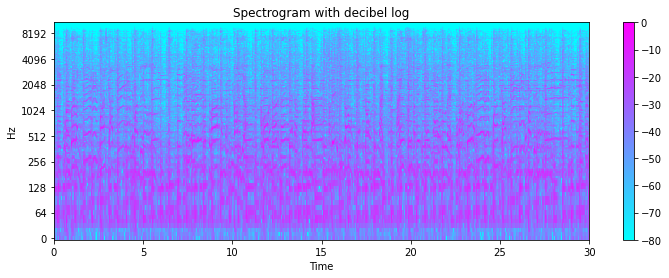

In [11]:
# Default FFT window size
n_fft = 2048 # window size
hop_length = 512 # window hop length for STFT

stft = librosa.stft(audio_data, n_fft=n_fft, hop_length=hop_length)
stft_db = librosa.amplitude_to_db(stft, ref=np.max)

plt.figure(figsize=(12,4))
lplt.specshow(stft, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title("Spectrogram with amplitude")
plt.show()

plt.figure(figsize=(12,4))
lplt.specshow(stft_db, sr=sr, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar()
plt.title("Spectrogram with decibel log")
plt.show()

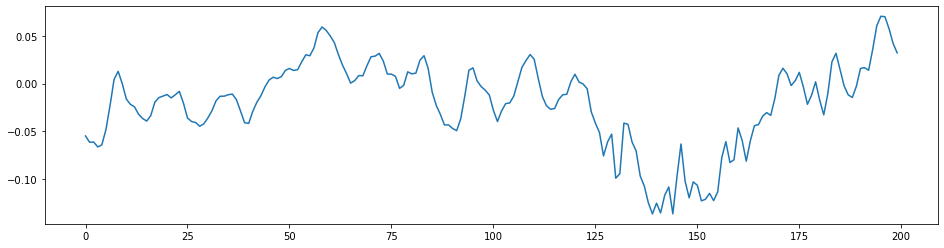

In [12]:
# plot zoomed audio wave 
start = 1000
end = 1200
plt.figure(figsize=(16,4))
plt.plot(audio_data[start:end])
plt.show()

<ipython-input-13-7014d2537efb>:1: FutureWarning: Pass y=[ 0.00732422  0.01660156  0.00762939 ... -0.05560303 -0.06106567
 -0.06417847] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_spec = librosa.feature.melspectrogram(audio_data, sr=sr)


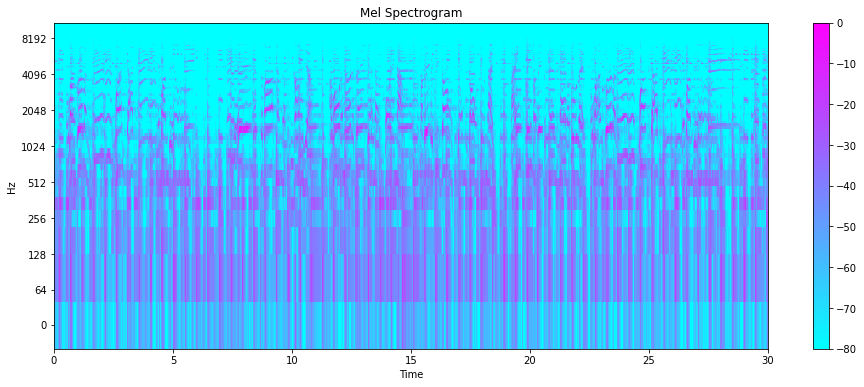

In [13]:
mel_spec = librosa.feature.melspectrogram(audio_data, sr=sr)
mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
plt.figure(figsize=(16,6))
lplt.specshow(mel_spec_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar()
plt.title("Mel Spectrogram")
plt.show()

<ipython-input-14-8e00ba421931>:1: FutureWarning: Pass y=[ 0.00732422  0.01660156  0.00762939 ... -0.05560303 -0.06106567
 -0.06417847] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  chroma = librosa.feature.chroma_stft(audio_data, sr=sr)


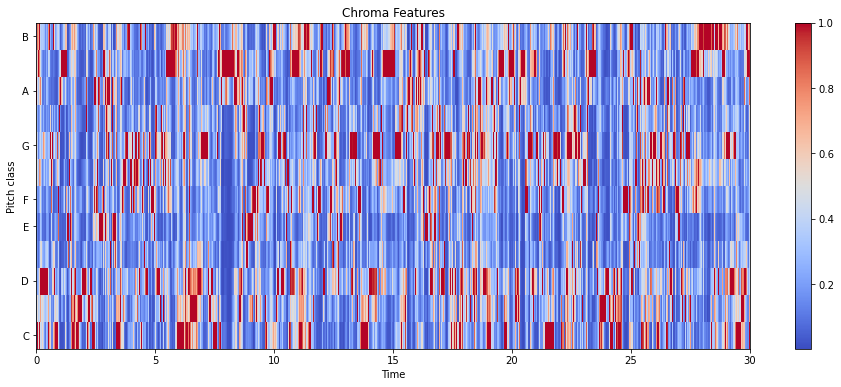

In [14]:
chroma = librosa.feature.chroma_stft(audio_data, sr=sr)
plt.figure(figsize=(16,6))
lplt.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma', cmap='coolwarm')
plt.colorbar()
plt.title("Chroma Features")
plt.show()

<ipython-input-15-adb3cbd9dc43>:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool))


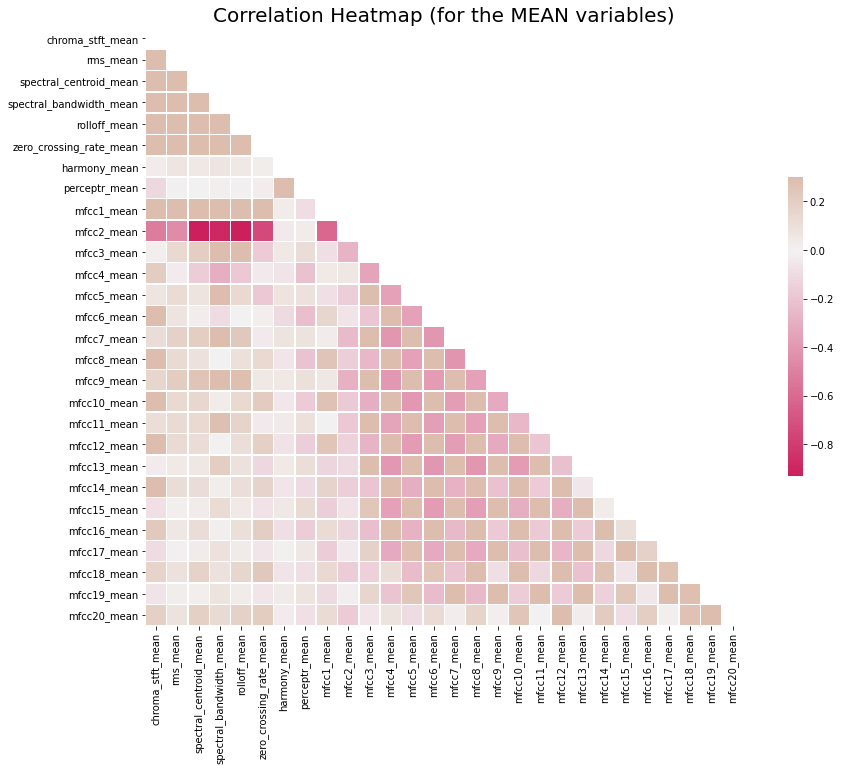

In [15]:
# Computing the Correlation Matrix
spike_cols = [col for col in df.columns if 'mean' in col]
corr = df[spike_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 11));

# Generate a custom diverging colormap
cmap = sns.diverging_palette(0, 25, as_cmap=True, s = 90, l = 45, n = 5)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap (for the MEAN variables)', fontsize = 20)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);
plt.savefig("Corr_Heatmap.png")

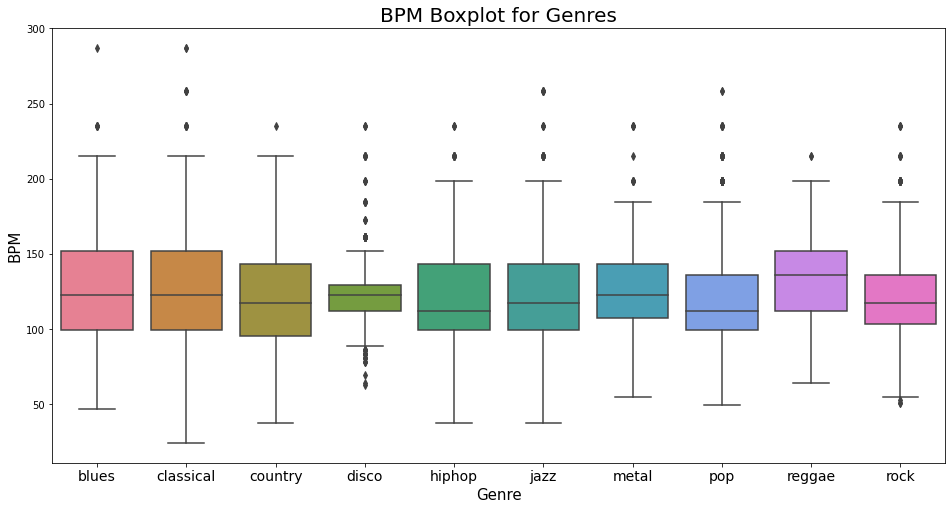

In [16]:
x = df[["label", "tempo"]]

fig, ax = plt.subplots(figsize=(16, 8));
sns.boxplot(x = "label", y = "tempo", data = x, palette = 'husl');

plt.title('BPM Boxplot for Genres', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 15)
plt.ylabel("BPM", fontsize = 15)
plt.savefig("BPM_Boxplot.png")

In [17]:
data['label']

NameError: name 'data' is not defined

In [ ]:
#@title
data = df.iloc[0:, 1:]
y = data['label']
X = data.loc[:, data.columns != 'label']

# normalize
cols = X.columns
min_max_scaler = skp.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)

# Top 2 pca components
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])

# concatenate with target label
finalDf = pd.concat([principalDf, y], axis = 1)

plt.figure(figsize = (16, 9))
sns.scatterplot(x = "pc1", y = "pc2", data = finalDf, hue = "label", alpha = 0.7, s = 100);

plt.title('PCA on Genres', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Principal Component 1", fontsize = 15)
plt.ylabel("Principal Component 2", fontsize = 15)
plt.savefig("PCA_Scattert.png")

In [ ]:
#New Dataset below

In [20]:
# Importing 1 file
y, sr = librosa.load('library/reggae/reggae.00036.wav')

print('y:', y, '\n')
print('y shape:', np.shape(y), '\n')
print('Sample Rate (KHz):', sr, '\n')

# Verify length of the audio
print('Check Len of Audio:', 661794/22050)

y: [0.02072144 0.04492188 0.05422974 ... 0.06912231 0.08303833 0.08572388] 

y shape: (661794,) 

Sample Rate (KHz): 22050 

Check Len of Audio: 30.013333333333332


In [21]:
# Trim leading and trailing silence from an audio signal (silence before and after the actual audio)
audio_file, _ = librosa.effects.trim(y)

# the result is an numpy ndarray
print('Audio File:', audio_file, '\n')
print('Audio File shape:', np.shape(audio_file))

Audio File: [0.02072144 0.04492188 0.05422974 ... 0.06912231 0.08303833 0.08572388] 

Audio File shape: (661794,)


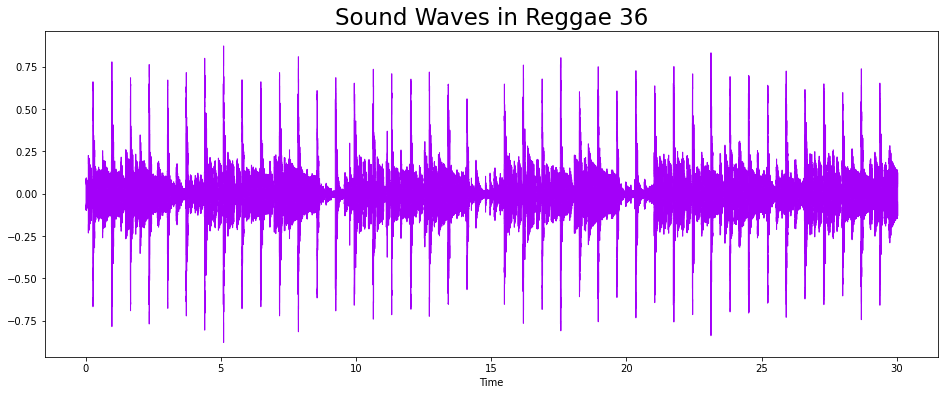

In [22]:
plt.figure(figsize = (16, 6))
librosa.display.waveshow(y = audio_file, sr = sr, color = "#A300F9");
plt.title("Sound Waves in Reggae 36", fontsize = 23);

In [23]:
# Default FFT window size
n_fft = 2048 # FFT window size
hop_length = 512 # number audio of frames between STFT columns (looks like a good default)

# Short-time Fourier transform (STFT)
D = np.abs(librosa.stft(audio_file, n_fft = n_fft, hop_length = hop_length))

print('Shape of D object:', np.shape(D))

Shape of D object: (1025, 1293)


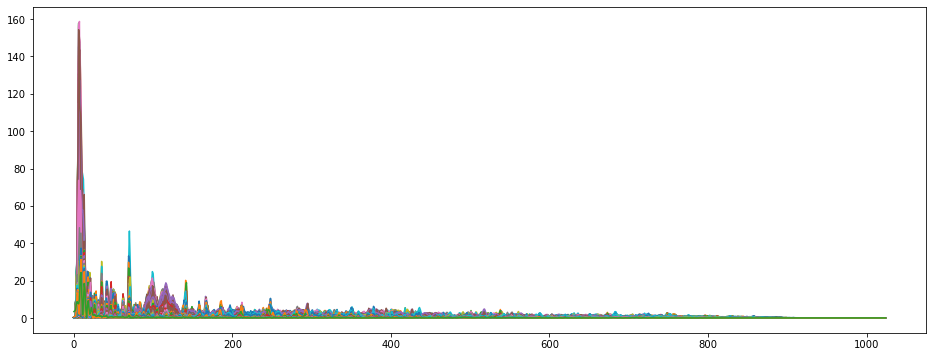

In [24]:
plt.figure(figsize = (16, 6))
plt.plot(D);

In [25]:
data = pd.read_csv('features_30_sec.csv')
data.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


<ipython-input-26-5964d7d8bc1e>:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool))


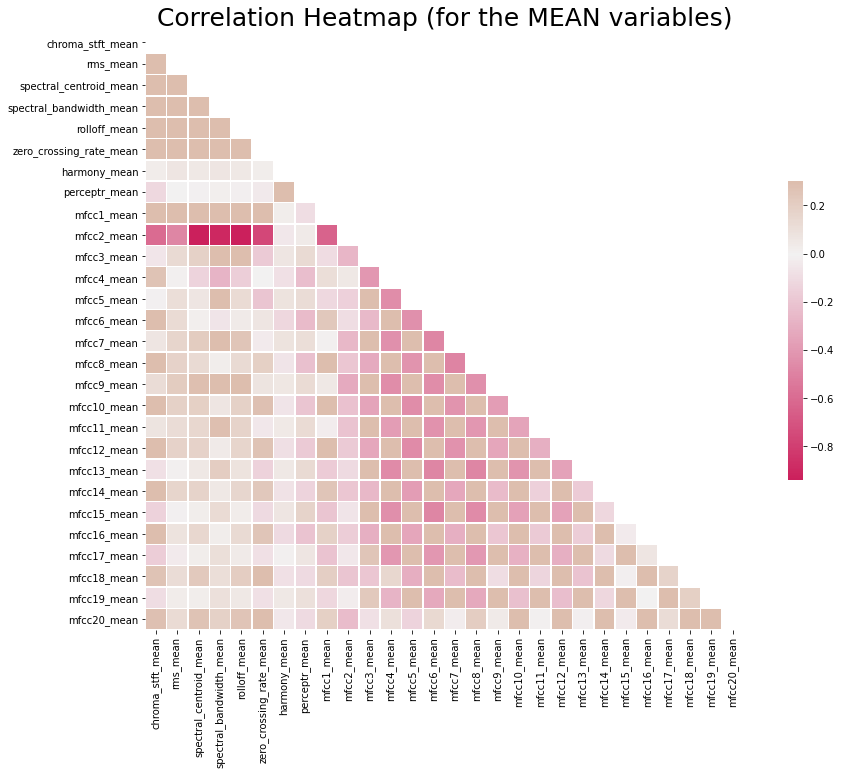

In [26]:
# Computing the Correlation Matrix
spike_cols = [col for col in data.columns if 'mean' in col]
corr = data[spike_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 11));

# Generate a custom diverging colormap
cmap = sns.diverging_palette(0, 25, as_cmap=True, s = 90, l = 45, n = 5)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap (for the MEAN variables)', fontsize = 25)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);
plt.savefig("Corr Heatmap.jpg")

## Random Forest - Base Model

In [27]:
# Split data into train / test set using an 70/30 split

data = df.iloc[0:, 1:]
y = data['label']
X = data.loc[:, data.columns != 'label']

from sklearn.model_selection import train_test_split
y = data['label']
X = data.loc[:, data.columns != 'label']

# normalize
cols = X.columns
min_max_scaler = skp.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [28]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [29]:
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)

In [30]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

[[264   1  24   7   2   5  12   0   3   1]
 [  0 296   1   0   0   9   0   0   1   1]
 [ 15   1 231   6   0  20   1   2   4   6]
 [  2   5   7 251  10   3   3   6   5   9]
 [  4   1   8   6 267   1   4  12   5   3]
 [  6  19   4   1   0 255   0   1   0   0]
 [  1   0   1   2   3   2 281   0   5   8]
 [  0   0   8   2   1   0   0 246   6   4]
 [  2   2   7   8   7   1   2  11 276   0]
 [  5   2  20  24   1  12  15   4   8 209]]
              precision    recall  f1-score   support

       blues       0.88      0.83      0.85       319
   classical       0.91      0.96      0.93       308
     country       0.74      0.81      0.77       286
       disco       0.82      0.83      0.83       301
      hiphop       0.92      0.86      0.89       311
        jazz       0.83      0.89      0.86       286
       metal       0.88      0.93      0.90       303
         pop       0.87      0.92      0.90       267
      reggae       0.88      0.87      0.88       316
        rock       0.87     

In [31]:
# Identify the top 5 features

d = {'names': X.columns, 'scores': rf.feature_importances_}
features = pd.DataFrame(data=d)
features = features.sort_values(by=['scores'], ascending = False)
features.head()

,names,scores
16,perceptr_var,0.050844
1,chroma_stft_mean,0.036062
4,rms_var,0.034948
24,mfcc4_mean,0.032169
3,rms_mean,0.031988


In [32]:
y_train_pred_rf = rf.predict(X_train)
print(classification_report(y_train, y_train_pred_rf))

              precision    recall  f1-score   support

       blues       1.00      1.00      1.00       681
   classical       1.00      1.00      1.00       690
     country       1.00      1.00      1.00       711
       disco       1.00      1.00      1.00       698
      hiphop       1.00      1.00      1.00       687
        jazz       1.00      1.00      1.00       714
       metal       1.00      1.00      1.00       697
         pop       1.00      1.00      1.00       733
      reggae       1.00      1.00      1.00       684
        rock       1.00      1.00      1.00       698

    accuracy                           1.00      6993
   macro avg       1.00      1.00      1.00      6993
weighted avg       1.00      1.00      1.00      6993



## CNN

In [2]:
# os.makedirs('C:/Users/cmurdock/Documents/Python Scripts/MachineLearning/FinalProject/spectrograms3sec')
# os.makedirs('C:/Users/cmurdock/Documents/Python Scripts/MachineLearning/FinalProject/spectrograms3sec/train')
# os.makedirs('C:/Users/cmurdock/Documents/Python Scripts/MachineLearning/FinalProject/spectrograms3sec/test')
# os.makedirs('C:/Users/cmurdock/Documents/Python Scripts/MachineLearning/FinalProject/library_by_genre')

genres = 'blues classical country disco pop hiphop metal reggae rock jazz'
genres = genres.split()
# for g in genres:
#   path_train = os.path.join('C:/Users/cmurdock/Documents/Python Scripts/MachineLearning/FinalProject/spectrograms3sec/train',f'{g}')
#   path_test = os.path.join('C:/Users/cmurdock/Documents/Python Scripts/MachineLearning/FinalProject/spectrograms3sec/test',f'{g}')
#   library_genre = os.path.join('C:/Users/cmurdock/Documents/Python Scripts/MachineLearning/FinalProject/library_by_genre',f'{g}')
#   os. makedirs(path_train)
#   os. makedirs(path_test)
#   os. makedirs(library_genre)

In [30]:
from pydub import AudioSegment

os.makedirs('C:/Users/cmurdock/Documents/Python Scripts/MachineLearning/FinalProject/library_by_class')
j = 0
for g in genres:
      for filename in os.listdir(os.path.join('C:/Users/cmurdock/Documents/Python Scripts/MachineLearning/FinalProject/library/',f"{g}")):
        song  =  os.path.join(f'C:/Users/cmurdock/Documents/Python Scripts/MachineLearning/FinalProject/library/{g}',f'{filename}')
        j = j+1
        audio = AudioSegment.from_wav(song)
        audio.export(f'C:/Users/cmurdock/Documents/Python Scripts/MachineLearning/FinalProject/library_by_genre/{g}/{filename}', format="wav")

C:\Users\cmurdock\Anaconda3\lib\site-packages\pydub\utils.py:198: RuntimeWarning: Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work
  warn("Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work", RuntimeWarning)


FileNotFoundError: [WinError 2] The system cannot find the file specified

blues
classical
country
disco
pop
hiphop
metal
reggae
rock
jazz


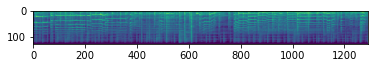

In [38]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

for g in genres:
  j = 0
  print(g)
  for filename in os.listdir(os.path.join('C:/Users/cmurdock/Documents/Python Scripts/MachineLearning/FinalProject/library_by_genre',f"{g}")):
    song  =  os.path.join(f'C:/Users/cmurdock/Documents/Python Scripts/MachineLearning/FinalProject/library_by_genre/{g}',f'{filename}')
    j = j+1
    
    y,sr = librosa.load(song,duration=30)
    mels = librosa.feature.melspectrogram(y=y,sr=sr)
    fig = plt.Figure()
    canvas = FigureCanvas(fig)
    p = plt.imshow(librosa.power_to_db(mels,ref=np.max))
    plt.savefig(f'C:/Users/cmurdock/Documents/Python Scripts/MachineLearning/FinalProject/spectrograms3sec/train/{g}/{g+str(j)}.png')

In [39]:
import shutil

directory = "C:/Users/cmurdock/Documents/Python Scripts/MachineLearning/FinalProject/spectrograms3sec/train/"
for g in genres:
  filenames = os.listdir(os.path.join(directory,f"{g}"))
  random.shuffle(filenames)
  test_files = filenames[0:5]

  for f in test_files:

    shutil.move(directory + f"{g}"+ "/" + f,"C:/Users/cmurdock/Documents/Python Scripts/MachineLearning/FinalProject/spectrograms3sec/test")

In [3]:
train_dir = "C:/Users/cmurdock/Documents/Python Scripts/MachineLearning/FinalProject/spectrograms3sec/train/"
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir,target_size=(288,432),color_mode="rgba",class_mode='categorical',batch_size=128)

Found 950 images belonging to 10 classes.


In [23]:
import tensorflow as tf
from tensorflow import keras

classifier = tf.keras.Sequential()

In [14]:
import cv2

img_path = 'C:/Users/cmurdock/Documents/Python Scripts/MachineLearning/FinalProject/spectrograms3sec/train/jazz/jazz34.png'
# Read the image
image = cv2.imread(img_path)

print(image.shape)

(288, 432, 3)


In [24]:
from keras.layers import Conv2D, Activation,MaxPooling2D, Flatten, Dense, Reshape, BatchNormalization

classifier.add(Conv2D(8, (3, 3), input_shape=(288,432,4), activation = 'relu'))
classifier.add(BatchNormalization(axis=3))
classifier.add(MaxPooling2D(pool_size=(3,3)))

In [25]:
classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier.add(BatchNormalization(axis=3))
classifier.add(MaxPooling2D(pool_size=(3,3)))

In [26]:
classifier.add(Conv2D(64, (3, 3), activation = 'relu'))
classifier.add(BatchNormalization(axis=3))
classifier.add(MaxPooling2D(pool_size=(3,3)))

In [27]:
classifier.add(Flatten())

In [28]:
classifier.add(Dense(10, activation = 'softmax'))

In [29]:
classifier.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['categorical_accuracy'])

In [30]:
classifier.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 286, 430, 8)       296       
                                                                 
 batch_normalization_6 (Batc  (None, 286, 430, 8)      32        
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 95, 143, 8)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 93, 141, 32)       2336      
                                                                 
 batch_normalization_7 (Batc  (None, 93, 141, 32)      128       
 hNormalization)                                                 
                                                      

In [31]:
classifier.fit(
        train_generator,
        steps_per_epoch=2,
        epochs=100)

Epoch 1/100
2/2 [==============================] - 8s 4s/step - loss: 6.5248 - categorical_accuracy: 0.1094
Epoch 2/100
2/2 [==============================] - 8s 3s/step - loss: 15.2673 - categorical_accuracy: 0.0898
Epoch 3/100
2/2 [==============================] - 6s 4s/step - loss: 19.2030 - categorical_accuracy: 0.1209
Epoch 4/100
2/2 [==============================] - 7s 3s/step - loss: 15.4956 - categorical_accuracy: 0.1250
Epoch 5/100
2/2 [==============================] - 8s 4s/step - loss: 16.2040 - categorical_accuracy: 0.1094
Epoch 6/100
2/2 [==============================] - 6s 2s/step - loss: 10.3414 - categorical_accuracy: 0.1209
Epoch 7/100
2/2 [==============================] - 5s 4s/step - loss: 9.5947 - categorical_accuracy: 0.0934
Epoch 8/100
2/2 [==============================] - 8s 4s/step - loss: 8.0056 - categorical_accuracy: 0.1250
Epoch 9/100
2/2 [==============================] - 8s 4s/step - loss: 6.6083 - categorical_accuracy: 0.1445
Epoch 10/100
2/2 [=====

In [ ]:
# save model to a file

classifier.save('CNN')
print("Saved model")